In [1]:
#from cityscapes_dataset import CityscapesDataset
from nyuv2_dataset import NYUv2Dataset
from cityscapes_dataset import CityscapesDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cross_stitchnet import CrossStitchNet
from densenet import DenseNet
from mtan import MTAN
from splitnet import SplitNet
from trainer import Trainer
from utils import count_params

2025-03-10 23:02:56.087208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 23:02:56.124841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 23:02:56.779339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
LABELS = 7
BATCH_SIZE = 2
LR = 1e-4

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
print("NYUv2 Dataset")
nyuv2_train = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='train')
classes = nyuv2_train.get_classes()

nyuv2_val = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='val')
train_dl = DataLoader(nyuv2_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(nyuv2_val, batch_size=BATCH_SIZE, shuffle=False)

for image, out in train_dl:
    print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)) + ',' + ' Normals: ' + str(list(out['normal'].shape)))
    print(f'Image: {image.max().item()}, {image.min().item()}') 
    print('Label: ' +  str(out['segmentation'].max().item()) + ',' + str(out['segmentation'].min().item()))
    print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
    print('Normals: ' + str(out['normal'].max().item()) + ', ' + str(out['normal'].min().item()))
    break
# ax, fig = plt.subplots(4, figsize=(10, 10))
# fig[0].imshow(image[0].permute(1, 2, 0))
# fig[1].imshow(label[0])
# fig[2].imshow(depth[0])
# fig[3].imshow(normals[0].permute(1, 2, 0))
# plt.show()

NYUv2 Dataset
Image: [2, 3, 288, 384], Label: [2, 288, 384], Depth: [2, 288, 384], Normals: [2, 3, 288, 384]
Image: 1.0, 0.0
Label: 11.0,-1.0
Depth: 4.014682292938232, 0.0
Normals: 0.9999846216542477, -0.9999846216542477


In [5]:
# print("Cityscapes Dataset")
# cityscapes = CityscapesDataset(root="../dataset/cityscapes_preprocessed")
# train_dl = DataLoader(cityscapes, batch_size=BATCH_SIZE, shuffle=True)
# classes = cityscapes.get_classes()
# for image, out in train_dl:
#     print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)))
#     print(f'Image: {image.max().item()}, {image.min().item()}') 
#     print('Label: ' +  str(out['segmentation'].max().item()) + ', ' + str(out['segmentation'].min().item()))
#     print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
#     break

In [6]:
# cityscapes_train = CityscapesDataset(root="../cityscapes_preprocessed", split="train",labels=LABELS)
# train_dl = DataLoader(cityscapes_train, batch_size=BATCH_SIZE, shuffle=False)
# for image, label, depth in train_dl:
#     print(f'Image: {image.shape}, Label: {label.shape}, Depth: {depth.shape}')
#     print(f'Image: {image.max()}, {image.min()}') 
#     print(f'Label: {label.max()}, {label.min()}')
#     print(f'Depth: {depth.max()}, {depth.min()}')
#     break
# ax, fig = plt.subplots(3, figsize=(10, 10))
# fig[0].imshow(image[0].permute(1, 2, 0))
# fig[1].imshow(label[0])
# fig[2].imshow(depth[0])
# plt.show()

# cityscapes_val = CityscapesDataset(root="../cityscapes_preprocessed", split="val", labels=LABELS)
# val_dl = DataLoader(cityscapes_val, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
model = CrossStitchNet(classes=classes, tasks=['segmentation', 'depth', 'normal'], depth_activation='sigmoid').to(device)
print(f"{model.name} has {count_params(model)} parameters")
# opt = torch.optim.Adam(model.parameters(), lr=1e-4)
# trainer = Trainer(model, opt)
# trainer.train(train_dl, val_dl, epochs=2, save=True)

cross_stitch_seg_dep_nor has 75141723 parameters


In [8]:
opt = torch.optim.Adam(model.parameters(), lr=LR)
trainer = Trainer(model, opt, "nyuv2", device)

100%|██████████| 398/398 [03:47<00:00,  1.75it/s]


Epoch 0/3 - Train Total Loss: 0.0429
lambda_segmentation : 4.894780197551051 - Train Loss segmentation: 1.5611
lambda_depth : 4.373701856236624 - Train Loss depth: 1.7843
lambda_normal : 4.7315179462123265 - Train Loss normal: 0.2654
miou: 0.1255418062210083
pix_acc: 0.46863290667533875
mae: 1.6575227975845337
mre: 0.34602877497673035
ad: 11.590987205505371
Gradient Norm: 15.286549903690554



100%|██████████| 327/327 [01:05<00:00,  4.96it/s]


Val Loss segmentation: 1.1954
Val Loss depth: 1.6656
Val Loss normal: 0.2803
miou: 0.11140458285808563
pix_acc: 0.44545891880989075
mae: 1.5913314819335938
mre: 0.3348100483417511
ad: 11.647521018981934




100%|██████████| 398/398 [03:48<00:00,  1.74it/s]


Epoch 1/3 - Train Total Loss: 0.0405
lambda_segmentation : 4.64582636716692 - Train Loss segmentation: 1.5336
lambda_depth : 4.857521752991256 - Train Loss depth: 1.7800
lambda_normal : 4.496651879841824 - Train Loss normal: 0.2549
miou: 0.13087405264377594
pix_acc: 0.4738062918186188
mae: 1.6575220823287964
mre: 0.3457617461681366
ad: 11.28411865234375
Gradient Norm: 12.591099742510607



100%|██████████| 327/327 [01:05<00:00,  4.96it/s]


Val Loss segmentation: 1.0240
Val Loss depth: 1.6656
Val Loss normal: 0.2844
miou: 0.13457605242729187
pix_acc: 0.47252047061920166
mae: 1.5913294553756714
mre: 0.33480948209762573
ad: 11.329171180725098




100%|██████████| 398/398 [03:48<00:00,  1.74it/s]


Epoch 2/3 - Train Total Loss: 0.0450
lambda_segmentation : 4.712008840283198 - Train Loss segmentation: 1.4943
lambda_depth : 4.472578150539553 - Train Loss depth: 1.7867
lambda_normal : 4.8154130091772505 - Train Loss normal: 0.2470
miou: 0.14131297171115875
pix_acc: 0.4903252124786377
mae: 1.657523512840271
mre: 0.34557774662971497
ad: 11.155070304870605
Gradient Norm: 16.86007129273927



100%|██████████| 327/327 [01:05<00:00,  4.97it/s]


Val Loss segmentation: 0.9326
Val Loss depth: 1.6656
Val Loss normal: 0.2604
miou: 0.12447351217269897
pix_acc: 0.4777681827545166
mae: 1.5913294553756714
mre: 0.3348095715045929
ad: 10.892447471618652




FileNotFoundError: [Errno 2] No such file or directory: '/mnt/5687e6b2-1adf-4c49-82ce-c30e45a94bfd/mds7108293/dl_project/src/models/cross_stitch_seg_dep_nor/cross_stitch_seg_dep_nor_train3.png'

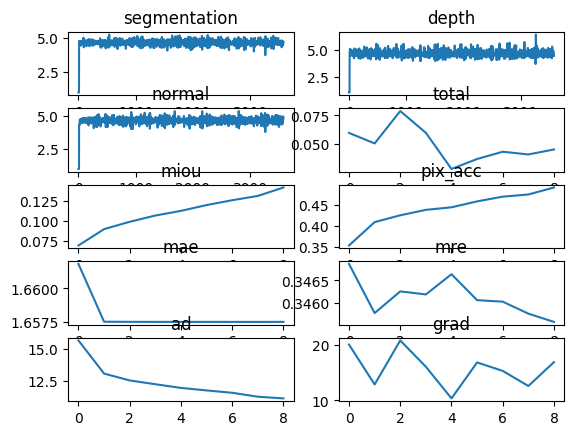

In [10]:
trainer.train(train_dl, val_dl, epochs=3, save=True, check=1, grad=True, dwa=5)

In [ ]:
# for x, y in train_dl:
#     x = x.to(device).to(torch.float)
#     y = {k: v.to(device) for k, v in y.items()}
#     y['segmentation'] = y['segmentation'].to(torch.long)
#     y['depth'] = y['depth'].to(torch.float)
#     out = model(x)
#     print(f"Segmentation: {out['segmentation'].shape}")
#     print(f"Depth: {out['depth'].shape}")
#     print(f"Normals: {out['normal'].shape}")
#     break

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# tests = 10
# path = 'models/mtan/mtan_train10.pth'
# model = MTAN(classes=LABELS)
# model.load_state_dict(torch.load(path, weights_only=True))
# model.to(device)
# for i, (img, img_seg, img_depth) in enumerate(val_dl):
#     visualize_results_multitask(model, img[0], img_seg[0], img_depth[0], device)
#     if i == tests:
#         break